12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing


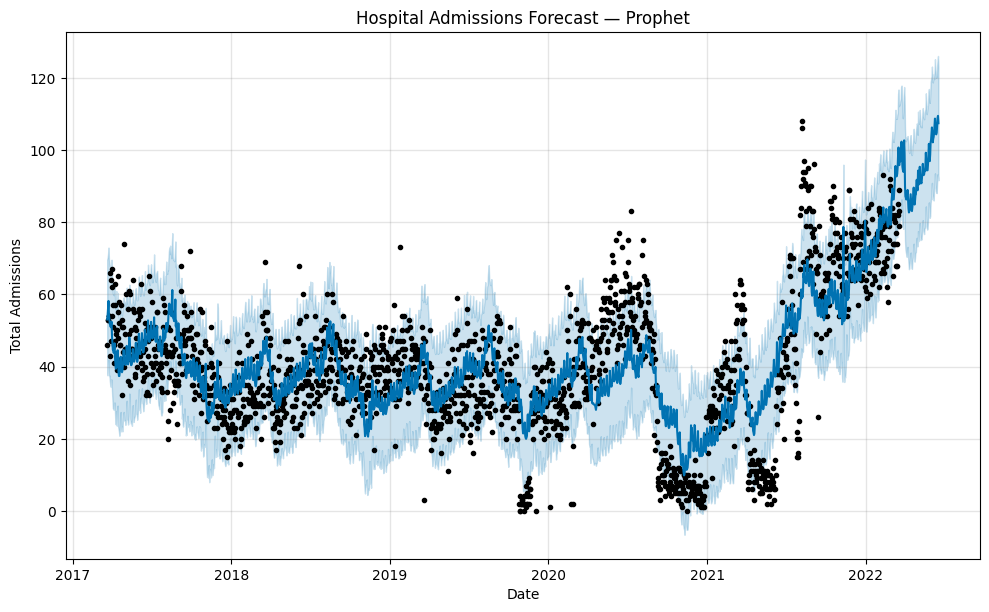


Forecast Preview:
           Date  Forecasted_Admissions  Lower_Bound  Upper_Bound
1819 2022-03-21              97.149010    81.559558   112.689631
1820 2022-03-22              96.882893    80.528185   113.545547
1821 2022-03-23              98.408506    82.032286   114.207796
1822 2022-03-24             101.071881    83.436338   117.499185
1823 2022-03-25             102.324056    86.355795   117.873160
...         ...                    ...          ...          ...
1904 2022-06-14             104.805646    88.070321   120.809991
1905 2022-06-15             107.076123    91.098637   123.355188
1906 2022-06-16             108.938188    93.306727   124.956529
1907 2022-06-17             109.474803    92.585119   126.081382
1908 2022-06-18             107.448767    91.628168   122.900373

[90 rows x 4 columns]


In [ ]:
# === Step 1: Install and import Prophet ===
# If not installed, uncomment below:
# !pip install prophet

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import pandas as pd
import matplotlib.pyplot as plt

hospital_data = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv")

# === Step 2: Prepare Data for Prophet ===
# Prophet expects two columns: 'ds' (date) and 'y' (target variable)

prophet_data = hospital_data.reset_index()[['ResidentDate', 'Total_Admissions']].rename(
    columns={'ResidentDate': 'ds', 'Total_Admissions': 'y'}
)

# Optional: Add exogenous features (holidays, etc.) separately if needed

# === Step 3: Add Regressors (optional) ===
# Prophet can take extra regressors — similar to exogenous variables in ARIMAX

exog_vars = [
    'is_weekend', 'season', 'temperature_max', 'temperature_min',
    'temp_range', 'precipitation', 'is_rain', 'Festival',
    'pandemic_flag', 'disaster_flag'
]
exog = hospital_data[exog_vars]

m = Prophet()

# Add extra regressors
for col in exog_vars:
    m.add_regressor(col)

# Combine exog variables with target for training
prophet_full = pd.concat([prophet_data, hospital_data[exog_vars].reset_index(drop=True)], axis=1)

# === Step 4: Fit the Prophet Model ===
m.fit(prophet_full)

# === Step 5: Create Future DataFrame ===
future = m.make_future_dataframe(periods=90, freq='D')

# Add exogenous features to future dataframe
future_exog = hospital_data[exog_vars].iloc[-90:].reset_index(drop=True)
future = pd.concat([future.iloc[-90:].reset_index(drop=True), future_exog], axis=1)
future_full = pd.concat([prophet_full[['ds'] + exog_vars], future], axis=0)

# === Step 6: Forecast ===
forecast = m.predict(future_full)

# === Step 7: Visualization ===
m.plot(forecast)
plt.title("Hospital Admissions Forecast — Prophet")
plt.xlabel("Date")
plt.ylabel("Total Admissions")
plt.grid(True)
plt.tight_layout()
plt.show()


# === Step 8: Forecast Table ===
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
forecast_table = forecast_table.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Admissions',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
})

print("\nForecast Preview:")
print(forecast_table.head(90))
